# Deep Crazyhouse


## Conversion of the Matrix- to Board Representation

* file: mat_to_board_demo.ipynb
* brief: Loads in a png-file from the lichess crazyhouse dataset and converts it to plane representation. The plane representations can later be used by a convolutional neural network.

* author: QueensGambit
* contact: johannes.czech@stud.tu-darmstadt.de
* version: 2018-07-01 visualized first game

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [19]:
import sys
sys.path.insert(0,'../../../')
import logging
from DeepCrazyhouse.src.domain.crazyhouse.input_representation import board_to_planes, planes_to_board
from DeepCrazyhouse.src.domain.crazyhouse.output_representation import policy_to_moves, policy_to_best_move, policy_to_move
from DeepCrazyhouse.src.preprocessing.dataset_loader import load_pgn_dataset
from DeepCrazyhouse.src.domain.crazyhouse.constants import LABELS, LABELS_MIRRORED, MV_LOOKUP, MV_LOOKUP_MIRRORED

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib
import datetime
from time import time
import numpy as np
import chess
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
t_s = time()
s_idcs_test, x_test, yv_test, yp_test, pgn_datasets_test = load_pgn_dataset(dataset_type='test', part_id=0,
                                                                           print_statistics=True, print_parameters=True, normalize=False)
t_e = time() - t_s
print('Elapsed time for loading(hh:mm:ss): ' + str(datetime.timedelta(seconds=round(time() - t_s))))

black_wins [307]
draws [19]
game_idx_end [1000]
game_idx_start [0]
number_selected_games [1000]
white_wins [674]
batch_size [1000]
compression [b'lz4']
limit_nb_games [0]
max_nb_files [1]
min_elo_both [2000]
pgn_name [b'sf_vs_sf_cz_test.pgn']
termination_conditions [b'Normal']
Elapsed time for loading(hh:mm:ss): 0:00:01


In [11]:
# Unflatten the x_train vector for these test
sample_idx = 42
s_idcs = s_idcs_test[sample_idx]
x = x_test[sample_idx]
yv = yv_test[sample_idx]
yp = yp_test[sample_idx]

### File Structure of the Dataset

In [12]:
pgn_datasets_test.tree()

/
 ├── metadata (1001, 17) |S128
 ├── parameters
 │   ├── batch_size (1,) int16
 │   ├── compression (1,) |S4
 │   ├── limit_nb_games (1,) int16
 │   ├── max_nb_files (1,) int16
 │   ├── min_elo_both (1,) int16
 │   ├── pgn_name (1,) |S21
 │   └── termination_conditions (1,) |S6
 ├── start_indices (1000,) int32
 ├── statistics
 │   ├── black_wins (1,) int16
 │   ├── draws (1,) int16
 │   ├── game_idx_end (1,) int16
 │   ├── game_idx_start (1,) int16
 │   ├── number_selected_games (1,) int16
 │   └── white_wins (1,) int16
 ├── x (90305, 34, 8, 8) int16
 ├── y_policy (90305, 2272) int16
 └── y_value (90305,) int16

### Show the Metadata of the first Game

In [13]:
metadata = np.array(pgn_datasets_test['metadata'])
metadata[0, :]
metadata[1, :]

array([b'Event', b'Site', b'Date', b'Round', b'White', b'Black',
       b'Result', b'BlackTimeControl', b'PlyCount', b'Variant',
       b'WhiteTimeControl', b'', b'', b'', b'', b'', b''], dtype='|S128')

array([b'Game 50 - Nodes: 839181-1107070 - Hash: 512', b'?',
       b'2019.01.01', b'1',
       b'Stockfish 2018-11-29 64 POPCNT Multi-Variant',
       b'Stockfish 2018-11-29 64 POPCNT Multi-Variant', b'0-1', b'inf',
       b'96', b'crazyhouse', b'inf', b'', b'', b'', b'', b'', b''],
      dtype='|S128')

### Game URL

In [14]:
print('The game can also be found at:', metadata[1, 1])

The game can also be found at: b'?'


### Visualize the first Game Moves

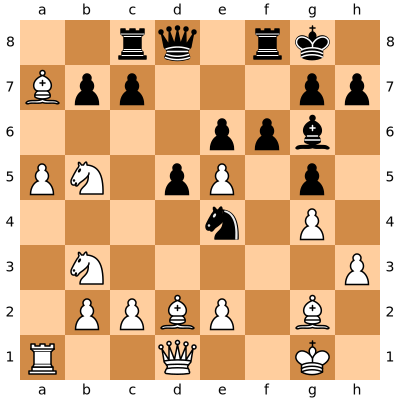

In [23]:
board = planes_to_board(x)
board

In [27]:
board.fen()

'2rq1rk1/Bpp3pp/4ppb1/PN1pP1p1/4n1P1/1N5P/1PPBP1B1/R2Q2K1[NPr] w - - 0 22'

In [28]:
board.turn

True

In [29]:
LABELS[yp.argmax()]

'b3c5'

In [27]:
def show_board_pos(x, yp):
    
    board = get_mat_of_current_board(x) 
    print("{0}'s turn".format(chess.COLOR_NAMES[board.turn]))
    print("black/white: {0}".format(board.pockets))
    
    planes = yp.reshape(78, 8, 8)
    next_move = get_move_representation(board, planes, is_white_to_move=board.turn)
    
    print("next move: {0}".format(next_move))

    return board, next_move

In [28]:
def set_chess_board():
    ax = plt.gca()
    ax.set_xticks([0,1,2,3,4,5,6,7])
    ax.set_xticklabels( ('a','b','c','d','e','f','g','h')) #, color=my_cmap)

    ax.set_yticks([0,1,2,3,4,5,6,7])
    ax.set_yticklabels(range(1,9)[::-1],color='black')

    ax.tick_params(labeltop=True, labelright=True)


In [31]:
# https://stackoverflow.com/questions/12073306/customize-colorbar-in-matplotlib
#255 143 31
cdict = {'red':  ( (0.0, 0.0, 0.0),   # <- at 0.0, the red component is 0
                   (0.5, 255/255, 255/255),   # <- at 0.5, the red component is 1
                   (1.0, 1.0, 1.0)),  # <- at 1.0, the red component is 0

         'green': ((0.0, 0.0, 0.0),   # <- etc.
                   (0.5, 143/255, 143/255),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (0.5, 31/255, 31/255),
                   (1.0, 1.0, 1.0))
         }

my_cmap = matplotlib.colors.LinearSegmentedColormap('my_colormap',cdict,256)

#for yp_cur in yp[:10]:
yp_mat = yp[2].reshape((78, 8, 8))
for i in range(78):
    tmp_sum = np.sum(yp_mat[i])
    #yp_mat[60, 0, 6] = 1.
    if tmp_sum != 0:
        print('Movement Channel:',i)
        #yp_mat[i, :, :] = 0
        #yp_mat[60, 0, 6] = 1.
        break
        
#plt.imshow(np.flipud(yp_mat[i]))


#for i in range(64):
#    if i % 2 == 0:
#        row, col = get_row_col(i)
#        chess_pattern[row, col] = 1

chess_pattern_flat = np.zeros(9*9)
chess_pattern_flat[::2] = 1


chess_pattern = chess_pattern_flat.reshape((9,9))[:8,:8]

# highlight the move
sel_idx = np.flipud(yp_mat[i]).argmax()

r, c = get_row_col(sel_idx)
chess_pattern[r, c] = 0.5

plt.imshow(chess_pattern, cmap=my_cmap)
set_chess_board()



plt.show()

ValueError: cannot reshape array of size 1 into shape (78,8,8)

In [32]:
b, move = show_board_pos(x[i], yp[i])

NameError: name 'i' is not defined

In [33]:
for i in range(17):
    show_board_pos(x[i], yp[i])

NameError: name 'get_mat_of_current_board' is not defined

### Visualize the last 10 moves

white's turn
black/white: [CrazyhousePocket('n'), CrazyhousePocket('nnppp')]
next move: d1e2


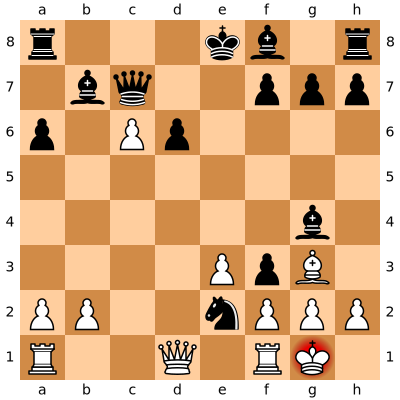

black's turn
black/white: [CrazyhousePocket('n'), CrazyhousePocket('nnnppp')]
next move: f3e2


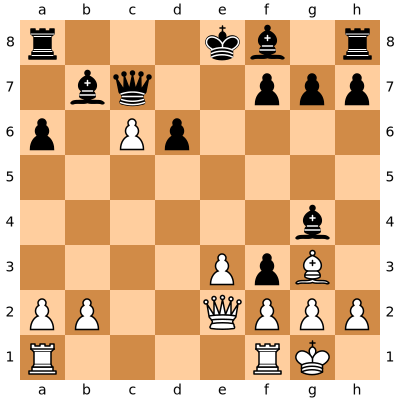

white's turn
black/white: [CrazyhousePocket('qn'), CrazyhousePocket('nnnppp')]
next move: P@d7


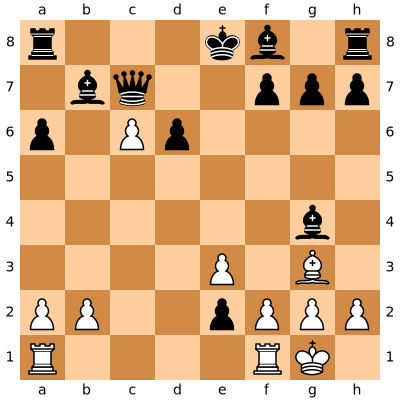

black's turn
black/white: [CrazyhousePocket('qn'), CrazyhousePocket('nnnpp')]
next move: g4d7


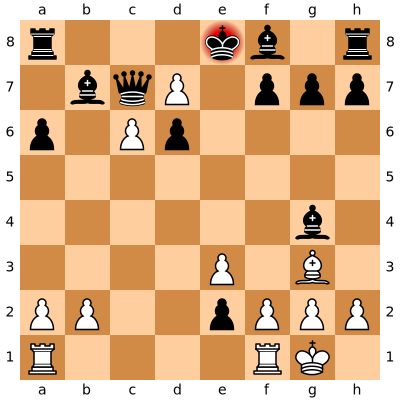

white's turn
black/white: [CrazyhousePocket('qnp'), CrazyhousePocket('nnnpp')]
next move: c6d7


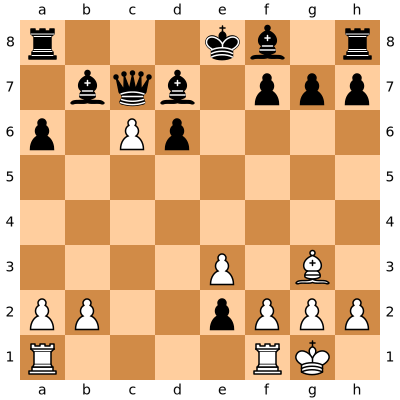

black's turn
black/white: [CrazyhousePocket('qnp'), CrazyhousePocket('bnnnpp')]
next move: c7d7


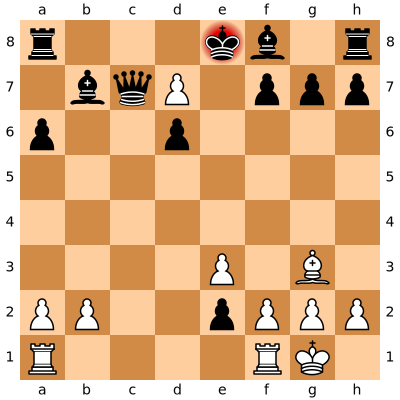

white's turn
black/white: [CrazyhousePocket('qnpp'), CrazyhousePocket('bnnnpp')]
next move: f1e1


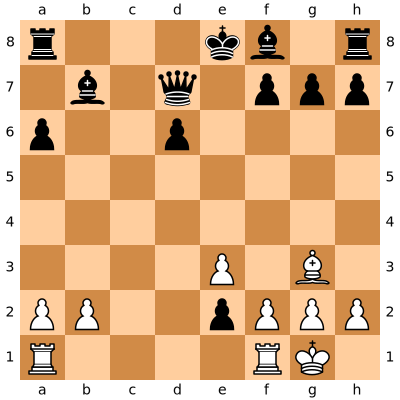

black's turn
black/white: [CrazyhousePocket('qnpp'), CrazyhousePocket('bnnnpp')]
next move: N@h3


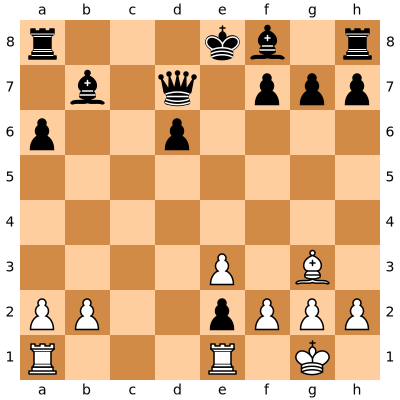

white's turn
black/white: [CrazyhousePocket('qpp'), CrazyhousePocket('bnnnpp')]
next move: g2h3


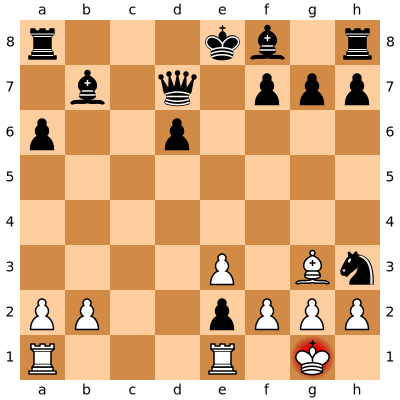

black's turn
black/white: [CrazyhousePocket('qpp'), CrazyhousePocket('bnnnnpp')]
next move: Q@g2


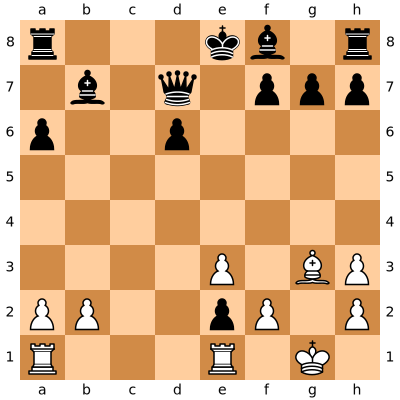

In [104]:
for i in range(s_idcs[1]-10, s_idcs[1]):
    show_board_pos(x[i], yp[i])

### Show Black's Pawn Formation in the last Position

In [ ]:
plt.imshow(x[s_idcs[1]-1][0], cmap='binary')